# Set-Up

In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, amortised
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze()), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

# Artificial Data Creation

In [5]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [6]:
# Define model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [7]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model, true_theta, noise_cov, prngkey)

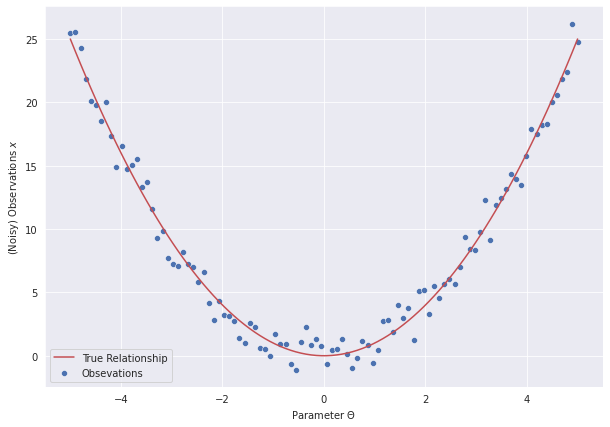

In [8]:
plot_data(data, true_theta, model)

# Create Joint Distribution

In [9]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [10]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.std_scaling(data)
amortised_dist = amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=3, width=5,  \
                                         activation='sigmoid', preprocessing=preprocessing)
# num_layers=3, width=10,

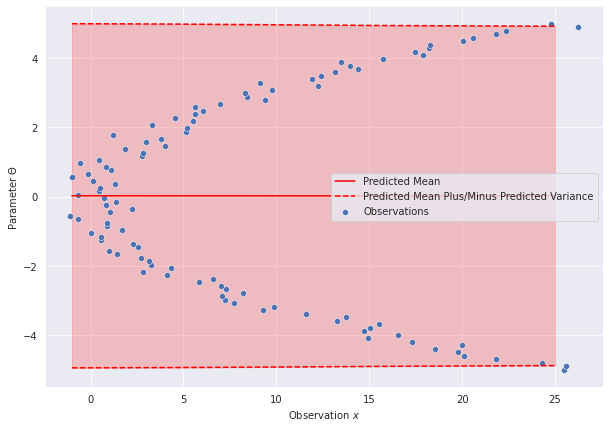

In [11]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [12]:
# Initialise:
target = Jaxtainer({'mean': 0, 'log_chol_diag': 0})
mse = losses.MSE(target)
optimiser = optimisers.Adam(lr=5e-3)
optimiser.fit(amortised_dist, mse, data, prngkey, verbose=True)

Loss = 82.18658447265625, Params = Jaxtainer({'W_0': DeviceArray([[-0.75913584, -0.01973878,  2.379394  ,  1.2282702 ,
               0.41732123]], dtype=float32), 'b_0': DeviceArray([-0.00499999, -0.00499999,  0.00499994, -0.00499994,
              0.00499998], dtype=float32), 'W_1': DeviceArray([[-0.06066358, -0.46731135, -0.57081705, -0.40556714,
               0.4293586 ],
             [-0.38993075,  1.165614  , -1.2469593 ,  0.5060226 ,
               0.08742531],
             [-0.46566457,  0.8329989 ,  0.12307294,  0.38274735,
              -0.33791187],
             [-0.21778592,  1.0808867 ,  0.7755841 , -0.42411828,
              -0.75266016],
             [-1.2449256 ,  0.7921966 ,  1.020199  ,  0.57591695,
               1.1448979 ]], dtype=float32), 'b_1': DeviceArray([ 0.005     , -0.00499999,  0.005     ,  0.005     ,
             -0.00499999], dtype=float32), 'W_2': DeviceArray([[ 0.30121264,  0.05195707,  0.86888206, -0.58234495,
              -0.8176523 ],
           

Loss = 53.841495513916016, Params = Jaxtainer({'W_0': DeviceArray([[-0.7341973 ,  0.00526418,  2.3771796 ,  1.2531856 ,
               0.44210002]], dtype=float32), 'b_0': DeviceArray([-0.02968491, -0.02985341,  0.02954085, -0.03017671,
              0.03013454], dtype=float32), 'W_1': DeviceArray([[-0.03563759, -0.49227464, -0.5459254 , -0.38068852,
               0.40846828],
             [-0.36490384,  1.1406493 , -1.2220765 ,  0.53089654,
               0.06682556],
             [-0.44061553,  0.807995  ,  0.14795496,  0.40763122,
              -0.35776892],
             [-0.19275407,  1.0559131 ,  0.800455  , -0.39924893,
              -0.7727647 ],
             [-1.2198808 ,  0.7672093 ,  1.0450988 ,  0.600811  ,
               1.1244588 ]], dtype=float32), 'b_1': DeviceArray([ 0.03003686, -0.02997845,  0.02989452,  0.0298859 ,
             -0.02561293], dtype=float32), 'W_2': DeviceArray([[ 0.27634758,  0.07688848,  0.8940072 , -0.6071551 ,
              -0.8423819 ],
          

Loss = 36.12727737426758, Params = Jaxtainer({'W_0': DeviceArray([[-0.7145165 ,  0.02507086,  2.392184  ,  1.2726091 ,
               0.46095765]], dtype=float32), 'b_0': DeviceArray([-0.048503  , -0.04922989,  0.04788107, -0.05060616,
              0.05033652], dtype=float32), 'W_1': DeviceArray([[-0.01564947, -0.5119427 , -0.5264214 , -0.3612357 ,
               0.40489677],
             [-0.34491172,  1.1209755 , -1.2026047 ,  0.5503321 ,
               0.06419052],
             [-0.42054534,  0.7881811 ,  0.16742109,  0.42709705,
              -0.35802248],
             [-0.1727431 ,  1.0362043 ,  0.81988454, -0.379831  ,
              -0.77389055],
             [-1.1998236 ,  0.7474506 ,  1.0646305 ,  0.6203162 ,
               1.1225812 ]], dtype=float32), 'b_1': DeviceArray([ 0.05006476, -0.04970318,  0.04940841,  0.04936349,
             -0.02816377], dtype=float32), 'W_2': DeviceArray([[ 0.25690925,  0.09647437,  0.9143077 , -0.626243  ,
              -0.86146086],
           

Loss = 22.61688804626465, Params = Jaxtainer({'W_0': DeviceArray([[-0.69544905,  0.04434536,  2.4093072 ,  1.290969  ,
               0.47784853]], dtype=float32), 'b_0': DeviceArray([-0.0657897 , -0.06769948,  0.06423202, -0.07109722,
              0.07036673], dtype=float32), 'W_1': DeviceArray([[ 0.00410447, -0.5309757 , -0.5076852 , -0.34260744,
               0.41380492],
             [-0.32514694,  1.1019279 , -1.183938  ,  0.568922  ,
               0.07394119],
             [-0.40060693,  0.7688308 ,  0.18606994,  0.44574383,
              -0.34623984],
             [-0.15293334,  1.0170759 ,  0.8384593 , -0.36128104,
              -0.7628819 ],
             [-1.179912  ,  0.72821474,  1.0834236 ,  0.63905233,
               1.1331661 ]], dtype=float32), 'b_1': DeviceArray([ 0.06990871, -0.06886119,  0.06816553,  0.06804273,
             -0.01824085], dtype=float32), 'W_2': DeviceArray([[ 0.23827341,  0.11537455,  0.93468374, -0.64407015,
              -0.8793917 ],
           

Loss = 12.948144912719727, Params = Jaxtainer({'W_0': DeviceArray([[-0.6774409 ,  0.06264369,  2.4218783 ,  1.3076056 ,
               0.49171114]], dtype=float32), 'b_0': DeviceArray([-0.08092841, -0.08478495,  0.07811905, -0.09122203,
              0.08984694], dtype=float32), 'W_1': DeviceArray([[ 0.0232884 , -0.5489809 , -0.49013966, -0.3252335 ,
               0.42931476],
             [-0.30594075,  1.0838948 , -1.1665087 ,  0.58623034,
               0.08996472],
             [-0.3810962 ,  0.7502909 ,  0.2034626 ,  0.4631349 ,
              -0.3289552 ],
             [-0.13364354,  0.9989004 ,  0.8557352 , -0.34404197,
              -0.7461108 ],
             [-1.1604469 ,  0.70986223,  1.1010588 ,  0.6565968 ,
               1.1498142 ]], dtype=float32), 'b_1': DeviceArray([ 0.08925106, -0.08707674,  0.08574411,  0.0854966 ,
             -0.00204619], dtype=float32), 'W_2': DeviceArray([[ 0.2208501 ,  0.13323364,  0.95484734, -0.66026276,
              -0.89564633],
          

Loss = 6.562715530395508, Params = Jaxtainer({'W_0': DeviceArray([[-0.66098344,  0.07937041,  2.420817  ,  1.3217902 ,
               0.5018667 ]], dtype=float32), 'b_0': DeviceArray([-0.09349377, -0.09996322,  0.08954693, -0.11017907,
              0.10811623], dtype=float32), 'W_1': DeviceArray([[ 0.04140821, -0.5654075 , -0.4742776 , -0.3096027 ,
               0.44747666],
             [-0.287784  ,  1.0674255 , -1.1508089 ,  0.6017675 ,
               0.10845163],
             [-0.36248446,  0.7331091 ,  0.21910436,  0.47877273,
              -0.3095929 ],
             [-0.11535681,  0.98222464,  0.8712215 , -0.3286051 ,
              -0.72714794],
             [-1.1419033 ,  0.6929407 ,  1.1170392 ,  0.6724523 ,
               1.1688312 ]], dtype=float32), 'b_1': DeviceArray([ 0.10760582, -0.10379715,  0.10164919,  0.10123115,
              0.01661734], dtype=float32), 'W_2': DeviceArray([[ 0.20509197,  0.14952879,  0.9743101 , -0.67434555,
              -0.9098556 ],
           

Loss = 2.771387815475464, Params = Jaxtainer({'W_0': DeviceArray([[-0.64653844,  0.09398788,  2.4082296 ,  1.3331332 ,
               0.5083201 ]], dtype=float32), 'b_0': DeviceArray([-0.10336705, -0.1128432 ,  0.09875299, -0.12717217,
              0.12452916], dtype=float32), 'W_1': DeviceArray([[ 0.05788334, -0.5797688 , -0.46051374, -0.2961108 ,
               0.46607873],
             [-0.27125725,  1.0530089 , -1.1372409 ,  0.6151444 ,
               0.12727104],
             [-0.34536284,  0.7178216 ,  0.2325982 ,  0.4922578 ,
              -0.2900756 ],
             [-0.09865601,  0.9675513 ,  0.8845335 , -0.31535235,
              -0.70799994],
             [-1.1248736 ,  0.6779715 ,  1.1309386 ,  0.68620086,
               1.188174  ]], dtype=float32), 'b_1': DeviceArray([ 0.12438301, -0.11851189,  0.11546107,  0.11483935,
              0.03563591], dtype=float32), 'W_2': DeviceArray([[ 0.19139408,  0.16381279,  0.99241173, -0.68609923,
              -0.92176664],
           

Loss = 0.8470877408981323, Params = Jaxtainer({'W_0': DeviceArray([[-0.6344648 ,  0.10611749,  2.3901289 ,  1.3416854 ,
               0.5117278 ]], dtype=float32), 'b_0': DeviceArray([-0.11073682, -0.12323911,  0.10602543, -0.14155498,
              0.13853921], dtype=float32), 'W_1': DeviceArray([[ 0.07211972, -0.5917145 , -0.4491262 , -0.2850051 ,
               0.48346692],
             [-0.25696006,  1.0410022 , -1.12606   ,  0.6261271 ,
               0.14480494],
             [-0.33038834,  0.7048849 ,  0.24369936,  0.5033444 ,
              -0.2719424 ],
             [-0.08415845,  0.9552682 ,  0.89544666, -0.30450293,
              -0.69023204],
             [-1.1100076 ,  0.6653769 ,  1.1424627 ,  0.69756424,
               1.2062453 ]], dtype=float32), 'b_1': DeviceArray([ 0.1389565 , -0.13082775,  0.12689531,  0.12605935,
              0.05339038], dtype=float32), 'W_2': DeviceArray([[ 0.18003967,  0.17576417,  1.0083833 , -0.6955382 ,
              -0.9312834 ],
          

Loss = 0.11198791116476059, Params = Jaxtainer({'W_0': DeviceArray([[-0.62498885,  0.1155607 ,  2.370998  ,  1.3478224 ,
               0.51316947]], dtype=float32), 'b_0': DeviceArray([-0.11601444, -0.13116454,  0.11159685, -0.15285237,
              0.14965919], dtype=float32), 'W_1': DeviceArray([[ 0.08358905, -0.60103333, -0.44026235, -0.2763952 ,
               0.49809414],
             [-0.2454322 ,  1.0316274 , -1.1173848 ,  0.63462305,
               0.15952538],
             [-0.3182073 ,  0.69466096,  0.25229946,  0.51192695,
              -0.25672105],
             [-0.07243798,  0.9456416 ,  0.90387803, -0.29613107,
              -0.6753487 ],
             [-1.0979322 ,  0.6554661 ,  1.1514456 ,  0.7063986 ,
               1.2214717 ]], dtype=float32), 'b_1': DeviceArray([ 0.15074581, -0.14047953,  0.13579817,  0.13476688,
              0.06832661], dtype=float32), 'W_2': DeviceArray([[ 0.17117704,  0.18512666,  1.0214729 , -0.7026882 ,
              -0.9385256 ],
         

Loss = 0.009203432127833366, Params = Jaxtainer({'W_0': DeviceArray([[-0.6181301 ,  0.12238341,  2.3552384 ,  1.3521117 ,
               0.51372266]], dtype=float32), 'b_0': DeviceArray([-0.11968078, -0.13682936,  0.11561253, -0.16102725,
              0.15775837], dtype=float32), 'W_1': DeviceArray([[ 0.09199047, -0.6077657 , -0.43386215, -0.27018985,
               0.5090052 ],
             [-0.23698811,  1.0248538 , -1.1111317 ,  0.6407384 ,
               0.17048845],
             [-0.3092572 ,  0.6872409 ,  0.25849023,  0.51810217,
              -0.24539573],
             [-0.06384803,  0.93867844,  0.90994126, -0.29011467,
              -0.664285  ],
             [-1.0890595 ,  0.648282  ,  1.1579328 ,  0.7127702 ,
               1.23283   ]], dtype=float32), 'b_1': DeviceArray([ 0.1593945 , -0.14746457,  0.14222564,  0.14104348,
              0.07946353], dtype=float32), 'W_2': DeviceArray([[ 0.16477387,  0.19191109,  1.0311257 , -0.7078084 ,
              -0.9436933 ],
        

Loss = 0.14429646730422974, Params = Jaxtainer({'W_0': DeviceArray([[-0.6137353 ,  0.12682578,  2.3474262 ,  1.3551152 ,
               0.514279  ]], dtype=float32), 'b_0': DeviceArray([-0.12219415, -0.14055245,  0.11818184, -0.16630894,
              0.16292875], dtype=float32), 'W_1': DeviceArray([[ 0.09729269, -0.6121225 , -0.42972326, -0.26616603,
               0.51573235],
             [-0.23167036,  1.0204775 , -1.1070831 ,  0.64470583,
               0.17723756],
             [-0.3036813 ,  0.68250185,  0.26249257,  0.5220973 ,
              -0.23846689],
             [-0.05846288,  0.9342    ,  0.91387194, -0.28621083,
              -0.65748966],
             [-1.0835097 ,  0.6436679 ,  1.1621172 ,  0.7168879 ,
               1.2397845 ]], dtype=float32), 'b_1': DeviceArray([ 0.16482867, -0.15196769,  0.14637803,  0.14510758,
              0.08630853], dtype=float32), 'W_2': DeviceArray([[ 0.1606456 ,  0.19627617,  1.0371335 , -0.7111723 ,
              -0.9470822 ],
         

Loss = 0.2883431315422058, Params = Jaxtainer({'W_0': DeviceArray([[-0.6115011 ,  0.12924436,  2.349773  ,  1.3572829 ,
               0.5153911 ]], dtype=float32), 'b_0': DeviceArray([-0.12392531, -0.14269711,  0.11945236, -0.16910751,
              0.16547611], dtype=float32), 'W_1': DeviceArray([[ 0.09974627, -0.6144395 , -0.42753172, -0.26400387,
               0.51838017],
             [-0.22923332,  1.0181649 , -1.1049207 ,  0.6468481 ,
               0.17988765],
             [-0.3012774 ,  0.680134  ,  0.2646246 ,  0.5242345 ,
              -0.23583332],
             [-0.0560505 ,  0.93188024,  0.91599244, -0.28409392,
              -0.6548377 ],
             [-1.08107   ,  0.6413027 ,  1.1643112 ,  0.7190697 ,
               1.2424133 ]], dtype=float32), 'b_1': DeviceArray([ 0.16728213, -0.1543191 ,  0.14856935,  0.14727923,
              0.08895928], dtype=float32), 'W_2': DeviceArray([[ 0.15848584,  0.19851767,  1.0396905 , -0.7130714 ,
              -0.9490276 ],
          

Loss = 0.3480681777000427, Params = Jaxtainer({'W_0': DeviceArray([[-0.6110079,  0.1300658,  2.3607008,  1.3589212,  0.5172214]],            dtype=float32), 'b_0': DeviceArray([-0.1251327 , -0.143628  ,  0.11965606, -0.16995113,
              0.16590911], dtype=float32), 'W_1': DeviceArray([[ 0.09983733, -0.6151362 , -0.42689064, -0.26331624,
               0.5176075 ],
             [-0.2291885 ,  1.017494  , -1.1042545 ,  0.64754856,
               0.17910454],
             [-0.30153462,  0.6796816 ,  0.26527536,  0.52490234,
              -0.23680295],
             [-0.0561153 ,  0.9312871 ,  0.9166848 , -0.28338408,
              -0.6556524 ],
             [-1.0812349 ,  0.64074427,  1.1649169 ,  0.7197127 ,
               1.2414038 ]], dtype=float32), 'b_1': DeviceArray([ 0.16725159, -0.15495144,  0.14919844,  0.14794996,
              0.08808969], dtype=float32), 'W_2': DeviceArray([[ 0.15790528,  0.19906501,  1.0393298 , -0.7138628 ,
              -0.9498459 ],
             [-0.0

Loss = 0.3186741769313812, Params = Jaxtainer({'W_0': DeviceArray([[-0.6118029 ,  0.12971   ,  2.3771405 ,  1.3602079 ,
               0.51968485]], dtype=float32), 'b_0': DeviceArray([-0.12599048, -0.14367779,  0.11907628, -0.16933739,
              0.16475257], dtype=float32), 'W_1': DeviceArray([[ 0.0981656 , -0.61463404, -0.42739528, -0.26371607,
               0.51423347],
             [-0.23092894,  1.0180389 , -1.1046916 ,  0.64718723,
               0.17571262],
             [-0.30378053,  0.68065536,  0.26483476,  0.5244879 ,
              -0.2405061 ],
             [-0.0580297 ,  0.9319753 ,  0.91632605, -0.28370926,
              -0.65909827],
             [-1.0833478 ,  0.64152926,  1.164348  ,  0.71921885,
               1.2376294 ]], dtype=float32), 'b_1': DeviceArray([ 0.16536504, -0.1543082 ,  0.14867258,  0.14751291,
              0.08454358], dtype=float32), 'W_2': DeviceArray([[ 0.15848856,  0.19834477,  1.0367904 , -0.71382314,
              -0.9498592 ],
          

Loss = 0.23651166260242462, Params = Jaxtainer({'W_0': DeviceArray([[-0.61342347,  0.12858617,  2.3960567 ,  1.3612326 ,
               0.52250224]], dtype=float32), 'b_0': DeviceArray([-0.12659945, -0.14314334,  0.11802299, -0.16776858,
              0.16258566], dtype=float32), 'W_1': DeviceArray([[ 0.09537446, -0.61335105, -0.42864004, -0.2648212 ,
               0.5092427 ],
             [-0.23380151,  1.0193748 , -1.1058427 ,  0.6461364 ,
               0.17069861],
             [-0.3072751 ,  0.6825473 ,  0.26368958,  0.52337277,
              -0.24590087],
             [-0.06111303,  0.93349445,  0.91528624, -0.28470695,
              -0.6641798 ],
             [-1.0866888 ,  0.6431839 ,  1.1630217 ,  0.7179893 ,
               1.2321445 ]], dtype=float32), 'b_1': DeviceArray([ 0.16230316, -0.15283614,  0.14740063,  0.14635755,
              0.07933605], dtype=float32), 'W_2': DeviceArray([[ 0.1598249 ,  0.19681631,  1.0328745 , -0.7132604 ,
              -0.9493367 ],
         

Loss = 0.14370468258857727, Params = Jaxtainer({'W_0': DeviceArray([[-0.6154596 ,  0.12704875,  2.4151204 ,  1.362039  ,
               0.5253692 ]], dtype=float32), 'b_0': DeviceArray([-0.1270259 , -0.14227659,  0.1167688 , -0.16567233,
              0.1599055 ], dtype=float32), 'W_1': DeviceArray([[ 0.09205277, -0.6116523 , -0.4302712 , -0.26629978,
               0.50350475],
             [-0.23720793,  1.0211303 , -1.1073697 ,  0.64471847,
               0.16493385],
             [-0.311337  ,  0.68490744,  0.26217452,  0.52188724,
              -0.25206777],
             [-0.06474059,  0.9354487 ,  0.91388434, -0.28606454,
              -0.6700182 ],
             [-1.0905951 ,  0.6452901 ,  1.1613022 ,  0.7163737 ,
               1.2258807 ]], dtype=float32), 'b_1': DeviceArray([ 0.15869127, -0.15092772,  0.14573939,  0.14482269,
              0.07336386], dtype=float32), 'W_2': DeviceArray([[ 0.16154821,  0.1948699 ,  1.0283349 , -0.7124027 ,
              -0.9485222 ],
         

Loss = 0.06908852607011795, Params = Jaxtainer({'W_0': DeviceArray([[-0.6175681 ,  0.12539704,  2.432598  ,  1.3626559 ,
               0.5280061 ]], dtype=float32), 'b_0': DeviceArray([-0.12731405, -0.14128593,  0.11552625, -0.16342512,
              0.15714486], dtype=float32), 'W_1': DeviceArray([[ 0.08869553, -0.609848  , -0.43199155, -0.26787326,
               0.49778572],
             [-0.24064548,  1.0229895 , -1.1089886 ,  0.643204  ,
               0.15918565],
             [-0.31539536,  0.6873521 ,  0.26056963,  0.5203081 ,
              -0.2581999 ],
             [-0.06838784,  0.9375009 ,  0.9123877 , -0.28752017,
              -0.67584026],
             [-1.0945098 ,  0.6474911 ,  1.1594962 ,  0.71466595,
               1.219657  ]], dtype=float32), 'b_1': DeviceArray([ 0.15505531, -0.14891742,  0.14398895,  0.14319316,
              0.06741689], dtype=float32), 'W_2': DeviceArray([[ 0.16335414,  0.19284247,  1.0238013 , -0.7114534 ,
              -0.947606  ],
         

Loss = 0.023435842245817184, Params = Jaxtainer({'W_0': DeviceArray([[-0.6194941 ,  0.12385847,  2.447377  ,  1.3631134 ,
               0.5302184 ]], dtype=float32), 'b_0': DeviceArray([-0.12750089, -0.14033167,  0.11443403, -0.16131958,
              0.154625  ], dtype=float32), 'W_1': DeviceArray([[ 0.08566911, -0.60817343, -0.43357933, -0.26933286,
               0.49265555],
             [-0.24374257,  1.0247132 , -1.1104877 ,  0.64179564,
               0.15402536],
             [-0.31903198,  0.6895926 ,  0.25908327,  0.5188422 ,
              -0.26369885],
             [-0.07166827,  0.9393958 ,  0.910996  , -0.28887743,
              -0.6810702 ],
             [-1.0980228 ,  0.6495172 ,  1.1578318 ,  0.7130863 ,
               1.2140809 ]], dtype=float32), 'b_1': DeviceArray([ 0.15178409, -0.14705905,  0.14237343,  0.14168258,
              0.06208275], dtype=float32), 'W_2': DeviceArray([[ 0.16501516,  0.19098273,  1.0197402 , -0.7105573 ,
              -0.94673353],
        

Loss = 0.0016523066442459822, Params = Jaxtainer({'W_0': DeviceArray([[-0.6214036 ,  0.12232096,  2.461275  ,  1.363515  ,
               0.53223926]], dtype=float32), 'b_0': DeviceArray([-0.12764108, -0.13935472,  0.11338429, -0.1591897 ,
              0.15212286], dtype=float32), 'W_1': DeviceArray([[ 0.08269247, -0.60649586, -0.43516332, -0.27079368,
               0.48761332],
             [-0.24678998,  1.0264403 , -1.1119874 ,  0.6403827 ,
               0.14894606],
             [-0.32260317,  0.6918262 ,  0.2575934 ,  0.5173704 ,
              -0.269115  ],
             [-0.07489623,  0.9412925 ,  0.9095983 , -0.29024318,
              -0.68622595],
             [-1.1014719 ,  0.6515393 ,  1.156171  ,  0.71150583,
               1.2085975 ]], dtype=float32), 'b_1': DeviceArray([ 0.14856847, -0.14520037,  0.14076051,  0.14017008,
              0.05683598], dtype=float32), 'W_2': DeviceArray([[ 0.16666925,  0.1891324 ,  1.0157592 , -0.7096515 ,
              -0.9458479 ],
       

KeyboardInterrupt: 

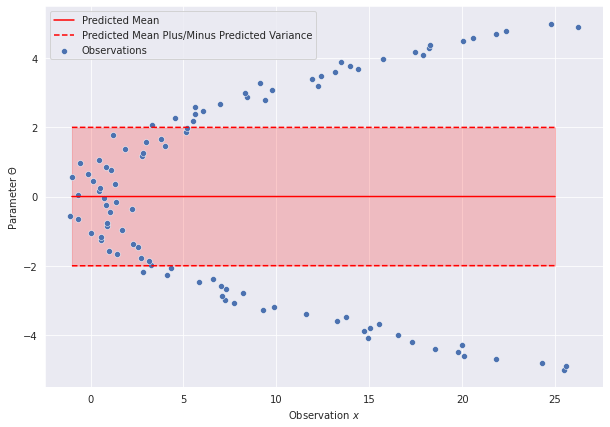

In [13]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [14]:
prngkey = jax.random.PRNGKey(20)
loss = losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=100, max_iter=200)

Loss = 61.07136535644531, Params = Jaxtainer({'W_0': DeviceArray([[-0.7217053 ,  0.22207835,  2.3634346 ,  1.4635782 ,
               0.43253976]], dtype=float32), 'b_0': DeviceArray([-0.22766015, -0.03919856,  0.01322138, -0.05884998,
              0.05172675], dtype=float32), 'W_1': DeviceArray([[-0.01777738, -0.50622976, -0.53541434, -0.37102544,
               0.38681793],
             [-0.34727153,  1.1267146 , -1.2122256 ,  0.5401581 ,
               0.04814348],
             [-0.42316815,  0.7921813 ,  0.15735611,  0.4171358 ,
              -0.36997253],
             [-0.17540702,  1.0415941 ,  0.8093757 , -0.39046088,
              -0.78704214],
             [-1.2020168 ,  0.7518603 ,  1.0559072 ,  0.6112547 ,
               1.1077309 ]], dtype=float32), 'b_1': DeviceArray([ 0.04806057, -0.04490533,  0.04050461,  0.03992982,
             -0.04399274], dtype=float32), 'W_2': DeviceArray([[ 0.26693153,  0.08883946,  0.91513085, -0.60950804,
              -0.84570634],
           

Loss = 55.74140548706055, Params = Jaxtainer({'W_0': DeviceArray([[-0.42338273,  0.5301144 ,  2.4690087 ,  1.7852447 ,
               0.39029226]], dtype=float32), 'b_0': DeviceArray([-0.47092742, -0.2654268 , -0.25845337, -0.24229823,
             -0.23497322], dtype=float32), 'W_1': DeviceArray([[ 0.20333618, -0.75509787, -0.29472512, -0.1369519 ,
               0.19603053],
             [-0.2579397 ,  0.9156474 , -1.171483  ,  0.5843767 ,
              -0.25031215],
             [-0.51571804,  0.77746993,  0.00771632,  0.3000041 ,
              -0.7050822 ],
             [-0.21347481,  0.9824764 ,  0.7157239 , -0.4563631 ,
              -1.132117  ],
             [-1.1359615 ,  0.56379086,  1.0748191 ,  0.6387856 ,
               0.8040908 ]], dtype=float32), 'b_1': DeviceArray([ 0.17814483, -0.2694417 ,  0.15102951,  0.14457683,
             -0.30912894], dtype=float32), 'W_2': DeviceArray([[ 0.06924312,  0.2776895 ,  1.065914  , -0.83555025,
              -1.0514985 ],
           

Loss = 55.742645263671875, Params = Jaxtainer({'W_0': DeviceArray([[-0.23923165,  0.7506817 ,  2.658421  ,  2.0069172 ,
               0.4047314 ]], dtype=float32), 'b_0': DeviceArray([-0.5862643 , -0.39730635, -0.39070582, -0.37336308,
             -0.4126749 ], dtype=float32), 'W_1': DeviceArray([[ 3.4263620e-01, -9.1081965e-01, -1.5638031e-01,
               1.1485815e-03,  8.4851801e-02],
             [-1.9062698e-01,  7.7718425e-01, -1.1279678e+00,
               6.4704609e-01, -4.7318873e-01],
             [-6.5516925e-01,  7.1493703e-01, -1.6050684e-01,
               1.7285475e-01, -9.7148103e-01],
             [-2.8628170e-01,  8.8726062e-01,  6.0236502e-01,
              -5.2806932e-01, -1.4029651e+00],
             [-1.0690386e+00,  4.2721260e-01,  1.1144483e+00,
               6.9822323e-01,  5.8084577e-01]], dtype=float32), 'b_1': DeviceArray([ 0.2786873 , -0.41627917,  0.23562112,  0.24003798,
             -0.4895035 ], dtype=float32), 'W_2': DeviceArray([[-5.7067584e-02,

Loss = 40.26633834838867, Params = Jaxtainer({'W_0': DeviceArray([[0.02846506, 0.85378134, 2.658966  , 2.0508215 , 0.33445358]],            dtype=float32), 'b_0': DeviceArray([-0.5354852 , -0.5014229 , -0.5935738 , -0.5276338 ,
             -0.56891096], dtype=float32), 'W_1': DeviceArray([[ 0.4520157 , -1.0454923 , -0.07404444,  0.09916226,
               0.0870617 ],
             [-0.09473574,  0.59213495, -1.1253041 ,  0.7108786 ,
              -0.41548967],
             [-0.62701285,  0.46483845, -0.31595308,  0.13973872,
              -0.90220207],
             [-0.23356797,  0.6497808 ,  0.485466  , -0.5315917 ,
              -1.3324144 ],
             [-0.98452014,  0.26164696,  1.1213224 ,  0.755416  ,
               0.5932874 ]], dtype=float32), 'b_1': DeviceArray([ 0.37817672, -0.57330215,  0.2773772 ,  0.31819338,
             -0.472631  ], dtype=float32), 'W_2': DeviceArray([[-0.14073437,  0.5286095 ,  1.3455782 , -1.0937827 ,
              -1.2027711 ],
             [-0.11

Loss = 42.52534484863281, Params = Jaxtainer({'W_0': DeviceArray([[0.39912418, 0.87379396, 2.466767  , 1.9417048 , 0.14390096]],            dtype=float32), 'b_0': DeviceArray([-0.4004755 , -0.5790683 , -0.78811073, -0.65931374,
             -0.7134951 ], dtype=float32), 'W_1': DeviceArray([[ 0.55357486, -1.1674397 , -0.00876681,  0.18052304,
               0.04355435],
             [ 0.07231496,  0.37876326, -1.1151568 ,  0.7925914 ,
              -0.26698816],
             [-0.39948988,  0.14742237, -0.4118426 ,  0.19844535,
              -0.6769379 ],
             [-0.01254087,  0.35059065,  0.4156124 , -0.46266907,
              -1.1126646 ],
             [-0.86951333,  0.08917175,  1.133864  ,  0.8193613 ,
               0.6210017 ]], dtype=float32), 'b_1': DeviceArray([ 0.4785367 , -0.72408986,  0.3177835 ,  0.39197534,
             -0.52883524], dtype=float32), 'W_2': DeviceArray([[-0.20345987,  0.616367  ,  1.4128369 , -1.0946792 ,
              -1.2842091 ],
             [-0.16

Loss = 36.8153076171875, Params = Jaxtainer({'W_0': DeviceArray([[ 0.73159015,  0.8902823 ,  2.2587454 ,  1.8256043 ,
              -0.01323946]], dtype=float32), 'b_0': DeviceArray([-0.2871216 , -0.63079894, -0.9199591 , -0.7447676 ,
             -0.8110989 ], dtype=float32), 'W_1': DeviceArray([[ 0.63891906, -1.2566277 ,  0.04977692,  0.24450463,
              -0.01051762],
             [ 0.23276114,  0.22681552, -1.0821224 ,  0.8665296 ,
              -0.13305995],
             [-0.14924067, -0.07198249, -0.4237886 ,  0.2808224 ,
              -0.45052686],
             [ 0.22462182,  0.14244503,  0.41641375, -0.37881774,
              -0.8944374 ],
             [-0.78332484, -0.03838837,  1.151957  ,  0.8686631 ,
               0.6032772 ]], dtype=float32), 'b_1': DeviceArray([ 0.5431504 , -0.83943087,  0.35395747,  0.44615507,
             -0.6437751 ], dtype=float32), 'W_2': DeviceArray([[-0.24797426,  0.67662275,  1.3501287 , -1.0063034 ,
              -1.4152167 ],
            

Loss = 38.483680725097656, Params = Jaxtainer({'W_0': DeviceArray([[ 0.966214  ,  0.91339374,  2.0999415 ,  1.7421135 ,
              -0.10470311]], dtype=float32), 'b_0': DeviceArray([-0.1979905, -0.6645792, -1.0179484, -0.8044613, -0.8711094],            dtype=float32), 'W_1': DeviceArray([[ 0.7121795 , -1.3077129 ,  0.10618217,  0.2968517 ,
              -0.01928179],
             [ 0.3614663 ,  0.1358064 , -1.0390997 ,  0.9281651 ,
              -0.01194772],
             [ 0.05472711, -0.19377086, -0.3951566 ,  0.36012492,
              -0.2639872 ],
             [ 0.41734558,  0.02498418,  0.45111677, -0.30108422,
              -0.71293366],
             [-0.7196284 , -0.1258001 ,  1.1712238 ,  0.90520304,
               0.59711516]], dtype=float32), 'b_1': DeviceArray([ 0.5936552 , -0.9181473 ,  0.3886156 ,  0.48719236,
             -0.7143306 ], dtype=float32), 'W_2': DeviceArray([[-0.28318745,  0.72726977,  1.3589212 , -0.9716325 ,
              -1.481262  ],
             [-0.

Loss = 36.72409439086914, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1213248 ,  0.93926203,  1.9898958 ,  1.6888055 ,
              -0.15558188]], dtype=float32), 'b_0': DeviceArray([-0.13301407, -0.68645185, -1.0864692 , -0.84433097,
             -0.9064604 ], dtype=float32), 'W_1': DeviceArray([[ 0.76964474, -1.330719  ,  0.15754567,  0.33924133,
              -0.02018288],
             [ 0.45730257,  0.08594351, -0.9960291 ,  0.9774861 ,
               0.07528777],
             [ 0.2070963 , -0.25226122, -0.3527553 ,  0.42865255,
              -0.1338133 ],
             [ 0.5612692 , -0.03310455,  0.49639678, -0.23509376,
              -0.5857851 ],
             [-0.67461634, -0.1863088 ,  1.1885276 ,  0.93123466,
               0.5981708 ]], dtype=float32), 'b_1': DeviceArray([ 0.6309765 , -0.9709091 ,  0.41965404,  0.51754844,
             -0.7552345 ], dtype=float32), 'W_2': DeviceArray([[-3.1147110e-01,  7.7041143e-01,  1.4242831e+00,
              -9.9739617e-01, -1.4882888e+0

Loss = 36.950138092041016, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2238582 ,  0.970082  ,  1.9203812 ,  1.6592666 ,
              -0.18429308]], dtype=float32), 'b_0': DeviceArray([-0.08435767, -0.70338863, -1.1332426 , -0.8710202 ,
             -0.92745554], dtype=float32), 'W_1': DeviceArray([[ 0.81197023, -1.3403052 ,  0.20081514,  0.37216398,
              -0.02990375],
             [ 0.5261402 ,  0.05810323, -0.958322  ,  1.0154282 ,
               0.127618  ],
             [ 0.31856763, -0.27603117, -0.3100387 ,  0.485901  ,
              -0.05534481],
             [ 0.66624427, -0.05879846,  0.5403649 , -0.18094718,
              -0.50913125],
             [-0.6461849 , -0.23395827,  1.2020214 ,  0.94687986,
               0.6075836 ]], dtype=float32), 'b_1': DeviceArray([ 0.6539595 , -1.0135515 ,  0.4446047 ,  0.5363044 ,
             -0.77352417], dtype=float32), 'W_2': DeviceArray([[-0.33289337,  0.8034112 ,  1.4813871 , -1.0345774 ,
              -1.4829291 ],
          

Loss = 36.57533264160156, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2935568 ,  1.0084051 ,  1.8847802 ,  1.6497313 ,
              -0.20636958]], dtype=float32), 'b_0': DeviceArray([-0.05053563, -0.72099257, -1.166844  , -0.8905768 ,
             -0.93711257], dtype=float32), 'W_1': DeviceArray([[ 0.8406453 , -1.345006  ,  0.23501705,  0.39613327,
              -0.05226712],
             [ 0.57349914,  0.04142413, -0.9279677 ,  1.0431733 ,
               0.15040985],
             [ 0.39962342, -0.28070152, -0.27351737,  0.532496  ,
              -0.02030231],
             [ 0.7418222 , -0.06702452,  0.5774242 , -0.13786888,
              -0.47487187],
             [-0.6335513 , -0.27738908,  1.2121291 ,  0.95262474,
               0.63172865]], dtype=float32), 'b_1': DeviceArray([ 0.66099507, -1.0557561 ,  0.46377993,  0.5432163 ,
             -0.765949  ], dtype=float32), 'W_2': DeviceArray([[-0.3484219 ,  0.8253681 ,  1.4891255 , -1.0532733 ,
              -1.4940182 ],
           

Loss = 36.50294876098633, Params = Jaxtainer({'W_0': DeviceArray([[ 1.3443073 ,  1.0548702 ,  1.8783567 ,  1.6587346 ,
              -0.23445868]], dtype=float32), 'b_0': DeviceArray([-0.03292992, -0.7388804 , -1.1905098 , -0.90516275,
             -0.9354493 ], dtype=float32), 'W_1': DeviceArray([[ 0.8602403 , -1.3438283 ,  0.2611975 ,  0.41442534,
              -0.09976654],
             [ 0.6064649 ,  0.03469977, -0.904506  ,  1.064305  ,
               0.14078826],
             [ 0.46125975, -0.26976916, -0.2447492 ,  0.57156193,
              -0.02387293],
             [ 0.798458  , -0.06066338,  0.60650843, -0.10240139,
              -0.47954363],
             [-0.6345089 , -0.3176486 ,  1.2201561 ,  0.95198005,
               0.6636207 ]], dtype=float32), 'b_1': DeviceArray([ 0.6538945 , -1.0965705 ,  0.47892457,  0.54271525,
             -0.7474015 ], dtype=float32), 'W_2': DeviceArray([[-0.36012352,  0.84089726,  1.483962  , -1.0762422 ,
              -1.5033144 ],
           

Loss = 36.47715377807617, Params = Jaxtainer({'W_0': DeviceArray([[ 1.3865371 ,  1.110692  ,  1.8999851 ,  1.6862475 ,
              -0.27589166]], dtype=float32), 'b_0': DeviceArray([-0.03243084, -0.75586486, -1.2049054 , -0.915412  ,
             -0.92290944], dtype=float32), 'W_1': DeviceArray([[ 0.875245  , -1.3344451 ,  0.28085542,  0.42987838,
              -0.17864998],
             [ 0.63122225,  0.03867847, -0.88678473,  1.0818987 ,
               0.09844794],
             [ 0.51243615, -0.24364188, -0.2230323 ,  0.60623425,
              -0.06014258],
             [ 0.84480554, -0.03971449,  0.6284832 , -0.07123911,
              -0.518244  ],
             [-0.64748687, -0.3549921 ,  1.2268193 ,  0.9475223 ,
               0.69658077]], dtype=float32), 'b_1': DeviceArray([ 0.6345962, -1.1341043,  0.4911422,  0.5382693, -0.7307751],            dtype=float32), 'W_2': DeviceArray([[-0.3700058 ,  0.8535716 ,  1.4966403 , -1.1246495 ,
              -1.4993497 ],
             [-0.2

Loss = 36.31243133544922, Params = Jaxtainer({'W_0': DeviceArray([[ 1.4327012 ,  1.1822134 ,  1.9554939 ,  1.7358162 ,
              -0.33901033]], dtype=float32), 'b_0': DeviceArray([-0.05846859, -0.7766438 , -1.2159204 , -0.92629874,
             -0.8916737 ], dtype=float32), 'W_1': DeviceArray([[ 0.8844565 , -1.319207  ,  0.29602414,  0.44300118,
              -0.27518642],
             [ 0.6488836 ,  0.05092412, -0.87304586,  1.096998  ,
               0.03519726],
             [ 0.5576636 , -0.20470837, -0.20645732,  0.6384698 ,
              -0.11810916],
             [ 0.88447744, -0.0068262 ,  0.6453378 , -0.04268906,
              -0.5792075 ],
             [-0.67898893, -0.3950963 ,  1.2330546 ,  0.9381269 ,
               0.73849356]], dtype=float32), 'b_1': DeviceArray([ 0.5951423 , -1.1740234 ,  0.50191844,  0.52865094,
             -0.7063878 ], dtype=float32), 'W_2': DeviceArray([[-0.3786561 ,  0.8636935 ,  1.5096273 , -1.1843722 ,
              -1.4907948 ],
           

Loss = 36.304954528808594, Params = Jaxtainer({'W_0': DeviceArray([[ 1.4978334 ,  1.2792033 ,  2.0561585 ,  1.8151197 ,
              -0.44256112]], dtype=float32), 'b_0': DeviceArray([-0.13097984, -0.8095958 , -1.2344698 , -0.9464604 ,
             -0.82136494], dtype=float32), 'W_1': DeviceArray([[ 0.88308626, -1.3010232 ,  0.3082467 ,  0.4533227 ,
              -0.37282044],
             [ 0.6575185 ,  0.06914648, -0.8620487 ,  1.1097765 ,
              -0.03650574],
             [ 0.5991826 , -0.15421182, -0.19403674,  0.66953206,
              -0.18862078],
             [ 0.9182389 ,  0.03608566,  0.6582276 , -0.01592484,
              -0.6519514 ],
             [-0.7448492 , -0.44714284,  1.2407082 ,  0.9204323 ,
               0.8063863 ]], dtype=float32), 'b_1': DeviceArray([ 0.5185253 , -1.2251666 ,  0.51349354,  0.5104455 ,
             -0.65435046], dtype=float32), 'W_2': DeviceArray([[-0.3858524 ,  0.87076455,  1.4902406 , -1.232636  ,
              -1.4862816 ],
          

Loss = 36.09608459472656, Params = Jaxtainer({'W_0': DeviceArray([[ 1.5929829 ,  1.4100536 ,  2.2146041 ,  1.9329051 ,
              -0.62250805]], dtype=float32), 'b_0': DeviceArray([-0.26116577, -0.85625374, -1.2612993 , -0.97888225,
             -0.681945  ], dtype=float32), 'W_1': DeviceArray([[ 0.87331164, -1.2749519 ,  0.31572607,  0.46248809,
              -0.47372326],
             [ 0.6604887 ,  0.09798117, -0.856106  ,  1.122032  ,
              -0.11814609],
             [ 0.6436976 , -0.08589674, -0.19024123,  0.7018886 ,
              -0.27302516],
             [ 0.9517636 ,  0.09480188,  0.663149  ,  0.0113357 ,
              -0.73748946],
             [-0.86390483, -0.5180869 ,  1.2539458 ,  0.89230883,
               0.921351  ]], dtype=float32), 'b_1': DeviceArray([ 0.39261943, -1.2889435 ,  0.5286312 ,  0.483441  ,
             -0.56077725], dtype=float32), 'W_2': DeviceArray([[-0.39324033,  0.8763553 ,  1.4509437 , -1.2805084 ,
              -1.483739  ],
           

Loss = 35.7735595703125, Params = Jaxtainer({'W_0': DeviceArray([[ 1.7292564,  1.587333 ,  2.4503443,  2.1030605, -0.9417848]],            dtype=float32), 'b_0': DeviceArray([-0.45508134, -0.91386056, -1.2869922 , -1.023083  ,
             -0.4188558 ], dtype=float32), 'W_1': DeviceArray([[ 0.86416966, -1.2286571 ,  0.30839238,  0.473265  ,
              -0.59436756],
             [ 0.6666173 ,  0.1492633 , -0.8666663 ,  1.1364222 ,
              -0.2231629 ],
             [ 0.7043295 ,  0.01523001, -0.21303879,  0.7388292 ,
              -0.38397717],
             [ 0.99691975,  0.18356317,  0.6434179 ,  0.04224095,
              -0.84812814],
             [-1.0734838 , -0.6196898 ,  1.285546  ,  0.8498874 ,
               1.1418089 ]], dtype=float32), 'b_1': DeviceArray([ 0.20222153, -1.3630372 ,  0.5512511 ,  0.44837594,
             -0.39352167], dtype=float32), 'W_2': DeviceArray([[-0.4041571 ,  0.8825623 ,  1.4321194 , -1.3593239 ,
              -1.4817029 ],
             [-0.252

Loss = 34.41671371459961, Params = Jaxtainer({'W_0': DeviceArray([[ 1.9322206,  1.8430003,  2.8035073,  2.3586588, -1.4546201]],            dtype=float32), 'b_0': DeviceArray([-0.74132514, -0.98921233, -1.3115678 , -1.0914971 ,
              0.04270975], dtype=float32), 'W_1': DeviceArray([[ 0.8651944 , -1.1423823 ,  0.2537291 ,  0.4869013 ,
              -0.75663084],
             [ 0.685845  ,  0.24423394, -0.9315571 ,  1.154284  ,
              -0.3730659 ],
             [ 0.8014906 ,  0.1775305 , -0.31853884,  0.7827649 ,
              -0.5497398 ],
             [ 1.0700579 ,  0.32845876,  0.547052  ,  0.07866272,
              -1.0086234 ],
             [-1.4597065 , -0.7916867 ,  1.3909824 ,  0.7774377 ,
               1.5945263 ]], dtype=float32), 'b_1': DeviceArray([-0.0988617 , -1.4532703 ,  0.59454864,  0.40013063,
             -0.0477756 ], dtype=float32), 'W_2': DeviceArray([[-0.42213124,  0.8901871 ,  1.4663874 , -1.4924345 ,
              -1.4854965 ],
             [-0.25

Loss = 30.13180160522461, Params = Jaxtainer({'W_0': DeviceArray([[ 2.2084365,  2.2182975,  3.3128376,  2.7340715, -2.0966756]],            dtype=float32), 'b_0': DeviceArray([-1.0605117, -1.0378933, -1.2312536, -1.1439025,  0.5857811],            dtype=float32), 'W_1': DeviceArray([[ 0.9319412 , -0.95254815,  0.02277019,  0.50463104,
              -1.0877514 ],
             [ 0.7753081 ,  0.45312312, -1.1956428 ,  1.1767703 ,
              -0.68370813],
             [ 0.99877083,  0.48002177, -0.6687955 ,  0.8339346 ,
              -0.8637692 ],
             [ 1.2334522 ,  0.60649675,  0.21403708,  0.12105195,
              -1.3146389 ],
             [-2.0087147 , -1.0693935 ,  1.663609  ,  0.6683163 ,
               2.2242088 ]], dtype=float32), 'b_1': DeviceArray([-0.48874122, -1.5323676 ,  0.62151176,  0.34057388,
              0.4640926 ], dtype=float32), 'W_2': DeviceArray([[-0.45579734,  0.90031207,  1.7375399 , -1.7775294 ,
              -1.5102715 ],
             [-0.2520299 ,

Loss = 21.70050048828125, Params = Jaxtainer({'W_0': DeviceArray([[ 2.5156848,  2.6889768,  3.9289808,  3.2065   , -2.753864 ]],            dtype=float32), 'b_0': DeviceArray([-1.1459247 , -0.9113052 , -0.83015966, -0.9984709 ,
              0.7629092 ], dtype=float32), 'W_1': DeviceArray([[ 1.1279247 , -0.556939  , -0.43089893,  0.5249527 ,
              -1.6134452 ],
             [ 1.0077481 ,  0.8842309 , -1.6957463 ,  1.2021221 ,
              -1.1925774 ],
             [ 1.3436123 ,  1.0025511 , -1.2402743 ,  0.88566136,
              -1.3402957 ],
             [ 1.5436506 ,  1.1065232 , -0.3443073 ,  0.16460885,
              -1.7883856 ],
             [-2.5257466 , -1.3622514 ,  1.999985  ,  0.55705255,
               2.8248305 ]], dtype=float32), 'b_1': DeviceArray([-0.7812916 , -1.4565299 ,  0.48484614,  0.2873749 ,
              0.8340622 ], dtype=float32), 'W_2': DeviceArray([[-0.52442175,  0.91012067,  2.2812374 , -2.2791011 ,
              -1.5887145 ],
             [-0.25

Loss = 15.066930770874023, Params = Jaxtainer({'W_0': DeviceArray([[ 2.7176208,  3.0342531,  4.3304467,  3.522195 , -3.2174168]],            dtype=float32), 'b_0': DeviceArray([-1.2525603 , -0.8458396 , -0.5850731 , -0.9299559 ,
              0.89181244], dtype=float32), 'W_1': DeviceArray([[ 1.2868125 , -0.14806314, -0.79948115,  0.5437186 ,
              -2.0025034 ],
             [ 1.1908423 ,  1.3221273 , -2.0984385 ,  1.2250743 ,
              -1.5657455 ],
             [ 1.6003457 ,  1.4987578 , -1.6900824 ,  0.92975307,
              -1.6853862 ],
             [ 1.7807577 ,  1.5931764 , -0.7876574 ,  0.20245248,
              -2.1351578 ],
             [-2.9351525 , -1.637809  ,  2.3475664 ,  0.4322658 ,
               3.3007364 ]], dtype=float32), 'b_1': DeviceArray([-1.004431  , -1.3395543 ,  0.40430206,  0.23162742,
              1.1244677 ], dtype=float32), 'W_2': DeviceArray([[-0.61331624,  0.9114149 ,  2.794645  , -2.750497  ,
              -1.6964554 ],
             [-0.2

Loss = 12.271098136901855, Params = Jaxtainer({'W_0': DeviceArray([[ 2.7182765,  3.151488 ,  4.4111786,  3.534947 , -3.410147 ]],            dtype=float32), 'b_0': DeviceArray([-1.3980892 , -0.8069248 , -0.2874783 , -0.90589595,
              0.98255634], dtype=float32), 'W_1': DeviceArray([[ 1.3269026 ,  0.0837099 , -1.03874   ,  0.5527282 ,
              -2.2311938 ],
             [ 1.2229601 ,  1.5554519 , -2.3623137 ,  1.2342011 ,
              -1.7911186 ],
             [ 1.6547781 ,  1.7489321 , -1.9852492 ,  0.94878155,
              -1.8988078 ],
             [ 1.833367  ,  1.8495315 , -1.0736015 ,  0.21955574,
              -2.3384264 ],
             [-3.2050245 , -1.8492534 ,  2.5271907 ,  0.29987395,
               3.533074  ]], dtype=float32), 'b_1': DeviceArray([-1.1902256 , -1.3108115 ,  0.33234248,  0.16950622,
              1.2599856 ], dtype=float32), 'W_2': DeviceArray([[-0.6530514 ,  0.9129853 ,  3.0449445 , -2.9791675 ,
              -1.7426242 ],
             [-0.2

Loss = 11.957489013671875, Params = Jaxtainer({'W_0': DeviceArray([[ 2.6805234,  3.2221422,  4.546545 ,  3.5218194, -3.5219631]],            dtype=float32), 'b_0': DeviceArray([-1.0531983 , -0.4072895 ,  0.3313884 , -0.46590292,
              0.6005405 ], dtype=float32), 'W_1': DeviceArray([[ 1.3695241 ,  0.2546891 , -1.2586579 ,  0.5619144 ,
              -2.5796173 ],
             [ 1.2779524 ,  1.7360331 , -2.6383033 ,  1.2429472 ,
              -2.2061367 ],
             [ 1.7508166 ,  1.9530115 , -2.319339  ,  0.963436  ,
              -2.316754  ],
             [ 1.8958019 ,  2.0430963 , -1.3616991 ,  0.23392297,
              -2.6941433 ],
             [-3.2712646 , -1.8956728 ,  2.402662  ,  0.19936775,
               3.3636768 ]], dtype=float32), 'b_1': DeviceArray([-1.2350734 , -1.2363816 ,  0.10921905,  0.12362888,
              0.98033506], dtype=float32), 'W_2': DeviceArray([[-0.703469  ,  0.9106721 ,  3.264463  , -3.1802356 ,
              -1.7887077 ],
             [-0.2

Loss = 11.819477081298828, Params = Jaxtainer({'W_0': DeviceArray([[ 2.466005 ,  3.1036115,  4.313559 ,  3.2473855, -3.4262662]],            dtype=float32), 'b_0': DeviceArray([-1.0532799 , -0.21058694,  0.7693658 , -0.37339336,
              0.58890146], dtype=float32), 'W_1': DeviceArray([[ 1.2176226 ,  0.3367752 , -1.425577  ,  0.56681436,
              -2.875265  ],
             [ 1.0402384 ,  1.8043654 , -2.8574657 ,  1.2442605 ,
              -2.5686562 ],
             [ 1.4696982 ,  2.0174012 , -2.5938761 ,  0.9636382 ,
              -2.6917748 ],
             [ 1.6499726 ,  2.1158195 , -1.5850768 ,  0.23735729,
              -2.9978714 ],
             [-3.4326668 , -1.9215775 ,  2.1671216 ,  0.12645702,
               3.0509984 ]], dtype=float32), 'b_1': DeviceArray([-1.4485862 , -1.2153159 , -0.13484336,  0.08841738,
              0.61308914], dtype=float32), 'W_2': DeviceArray([[-0.72202873,  0.9115667 ,  3.308283  , -3.215762  ,
              -1.7904525 ],
             [-0.2

Loss = 10.48629379272461, Params = Jaxtainer({'W_0': DeviceArray([[ 2.100959 ,  2.8336027,  3.8390062,  2.7827501, -3.1500838]],            dtype=float32), 'b_0': DeviceArray([-0.9991074 ,  0.13620718,  1.3466632 , -0.17725536,
              0.6183888 ], dtype=float32), 'W_1': DeviceArray([[ 0.98530215,  0.4085276 , -1.5796496 ,  0.5716659 ,
              -3.2397952 ],
             [ 0.6761821 ,  1.8857923 , -3.0846157 ,  1.2439758 ,
              -3.0433865 ],
             [ 1.0593722 ,  2.126035  , -2.8991797 ,  0.95852405,
              -3.196395  ],
             [ 1.275546  ,  2.1925385 , -1.8058684 ,  0.23859915,
              -3.3882463 ],
             [-3.5757048 , -1.7807955 ,  1.7996467 ,  0.06957965,
               2.5592408 ]], dtype=float32), 'b_1': DeviceArray([-1.7062078 , -1.1157268 , -0.44603586,  0.06109393,
              0.08582272], dtype=float32), 'W_2': DeviceArray([[-0.75286305,  0.90809065,  3.340053  , -3.2397394 ,
              -1.8017082 ],
             [-0.29

Loss = 8.130951881408691, Params = Jaxtainer({'W_0': DeviceArray([[ 1.5752784,  2.4227126,  3.2148874,  2.1621165, -2.6397307]],            dtype=float32), 'b_0': DeviceArray([-1.0598391 ,  0.6273924 ,  2.014966  ,  0.11700491,
              0.83313006], dtype=float32), 'W_1': DeviceArray([[ 0.67092913,  0.50977653, -1.7224022 ,  0.5757027 ,
              -3.6081028 ],
             [ 0.21138856,  2.055034  , -3.319636  ,  1.2412978 ,
              -3.5447595 ],
             [ 0.5709361 ,  2.3844578 , -3.2296286 ,  0.94894505,
              -3.7360814 ],
             [ 0.8103938 ,  2.341929  , -2.0241086 ,  0.23714647,
              -3.7945576 ],
             [-3.7288792 , -1.4097246 ,  1.3612362 ,  0.02243363,
               2.0138445 ]], dtype=float32), 'b_1': DeviceArray([-2.0434377 , -0.8699964 , -0.79167676,  0.03828121,
             -0.4750596 ], dtype=float32), 'W_2': DeviceArray([[-0.7821566 ,  0.90459085,  3.3234963 , -3.222627  ,
              -1.8081204 ],
             [-0.31

Loss = 7.5140061378479, Params = Jaxtainer({'W_0': DeviceArray([[ 1.5908552,  2.5800834,  3.4820065,  2.1673758, -2.3347502]],            dtype=float32), 'b_0': DeviceArray([-1.2837647 ,  0.55377   ,  1.9976528 , -0.04795393,
              1.1009357 ], dtype=float32), 'W_1': DeviceArray([[ 0.8910194 ,  0.51006514, -1.7860174 ,  0.57843775,
              -3.7743442 ],
             [ 0.2747195 ,  1.980756  , -3.3891184 ,  1.2273138 ,
              -3.7190137 ],
             [ 0.58352566,  2.279305  , -3.3131456 ,  0.9119982 ,
              -3.9132204 ],
             [ 0.89520174,  2.2868435 , -2.099192  ,  0.22593483,
              -3.950486  ],
             [-3.9136808 , -1.5868567 ,  1.4137751 , -0.05619235,
               2.0018086 ]], dtype=float32), 'b_1': DeviceArray([-2.038576  , -0.9890315 , -0.80389035,  0.00217066,
             -0.5481404 ], dtype=float32), 'W_2': DeviceArray([[-0.8217712 ,  0.90027684,  3.4391017 , -3.3122184 ,
              -1.8505393 ],
             [-0.3153

Loss = 7.485433578491211, Params = Jaxtainer({'W_0': DeviceArray([[ 1.488199 ,  2.8560147,  3.8569484,  2.3238463, -2.0595303]],            dtype=float32), 'b_0': DeviceArray([-1.5557591 ,  0.3929084 ,  1.8389299 , -0.21460633,
              1.2236531 ], dtype=float32), 'W_1': DeviceArray([[ 0.9483532 ,  0.5088607 , -1.8152456 ,  0.5767871 ,
              -3.847268  ],
             [ 0.26784497,  1.9309516 , -3.4019356 ,  1.2048651 ,
              -3.7655199 ],
             [ 0.56420046,  2.1904638 , -3.3170185 ,  0.8626854 ,
              -3.9540956 ],
             [ 0.8881235 ,  2.2507265 , -2.121273  ,  0.20516142,
              -4.001637  ],
             [-3.9503186 , -1.7860795 ,  1.6006995 , -0.13622224,
               2.158354  ]], dtype=float32), 'b_1': DeviceArray([-2.0610592 , -1.11891   , -0.7079686 , -0.03650258,
             -0.45151567], dtype=float32), 'W_2': DeviceArray([[-0.84498966,  0.89724785,  3.4769294 , -3.3397858 ,
              -1.8701435 ],
             [-0.32

Loss = 7.142529010772705, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1914607,  2.994873 ,  4.0437303,  2.3808258, -1.7418388]],            dtype=float32), 'b_0': DeviceArray([-1.8041563 ,  0.36719057,  1.8156556 , -0.21455541,
              1.2619137 ], dtype=float32), 'W_1': DeviceArray([[ 0.8177776 ,  0.5353035 , -1.8440078 ,  0.5717465 ,
              -3.9144616 ],
             [ 0.13168351,  1.9684691 , -3.4378984 ,  1.1780658 ,
              -3.8366516 ],
             [ 0.4362575 ,  2.2147388 , -3.3639958 ,  0.80921793,
              -4.03066   ],
             [ 0.7372985 ,  2.2876616 , -2.1579292 ,  0.17892292,
              -4.065224  ],
             [-3.8787692 , -1.8393991 ,  1.6635833 , -0.20703174,
               2.2162142 ]], dtype=float32), 'b_1': DeviceArray([-2.1792226 , -1.135987  , -0.6903513 , -0.07282241,
             -0.43138716], dtype=float32), 'W_2': DeviceArray([[-0.85088557,  0.89508337,  3.415474  , -3.2850683 ,
              -1.8607327 ],
             [-0.33

Loss = 6.971686840057373, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2110181,  3.0556858,  4.114231 ,  2.4173725, -1.7424946]],            dtype=float32), 'b_0': DeviceArray([-1.8467308 ,  0.24235867,  1.7761968 , -0.34537232,
              1.2297139 ], dtype=float32), 'W_1': DeviceArray([[ 0.8696676 ,  0.47972006, -1.8625754 ,  0.56868386,
              -3.9699016 ],
             [ 0.1971753 ,  1.734997  , -3.449249  ,  1.1386012 ,
              -3.898876  ],
             [ 0.49674168,  1.9229077 , -3.3834674 ,  0.723138  ,
              -4.1047606 ],
             [ 0.7996892 ,  2.0920858 , -2.1739643 ,  0.14491856,
              -4.1206765 ],
             [-3.818719  , -2.1302483 ,  1.681025  , -0.3032747 ,
               2.2108347 ]], dtype=float32), 'b_1': DeviceArray([-2.1254485 , -1.3796129 , -0.69348747, -0.11951361,
             -0.45809647], dtype=float32), 'W_2': DeviceArray([[-0.86206365,  0.8941706 ,  3.443044  , -3.3061323 ,
              -1.8712854 ],
             [-0.33

Loss = 6.947458267211914, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1534625,  2.9925997,  4.03315  ,  2.338619 , -1.6450105]],            dtype=float32), 'b_0': DeviceArray([-1.8726048 ,  0.30292147,  1.9119987 , -0.31429076,
              1.2344335 ], dtype=float32), 'W_1': DeviceArray([[ 0.88126403,  0.46626294, -1.8926479 ,  0.56695306,
              -4.041458  ],
             [ 0.19718337,  1.653919  , -3.5107164 ,  1.1161246 ,
              -4.013463  ],
             [ 0.49630886,  1.8347694 , -3.4911206 ,  0.6830941 ,
              -4.2494164 ],
             [ 0.7969048 ,  2.0239484 , -2.2288814 ,  0.12419982,
              -4.2135663 ],
             [-3.7976706 , -2.1977336 ,  1.5466776 , -0.34630856,
               2.0981197 ]], dtype=float32), 'b_1': DeviceArray([-2.1258998 , -1.4359481 , -0.80742395, -0.14124323,
             -0.5803174 ], dtype=float32), 'W_2': DeviceArray([[-0.8683468 ,  0.89355767,  3.4464445 , -3.3050592 ,
              -1.8739839 ],
             [-0.33

Loss = 6.834778785705566, Params = Jaxtainer({'W_0': DeviceArray([[ 1.080934 ,  2.8860765,  3.9007638,  2.2187958, -1.5164001]],            dtype=float32), 'b_0': DeviceArray([-1.8941675 ,  0.42978767,  2.1030695 , -0.22691257,
              1.2644002 ], dtype=float32), 'W_1': DeviceArray([[ 0.87611955,  0.46937454, -1.9233134 ,  0.56634086,
              -4.108443  ],
             [ 0.16847987,  1.634304  , -3.586055  ,  1.1021866 ,
              -4.133961  ],
             [ 0.4690587 ,  1.8318624 , -3.6240108 ,  0.66615194,
              -4.4051304 ],
             [ 0.7663906 ,  2.006632  , -2.293322  ,  0.11054585,
              -4.3086224 ],
             [-3.8013465 , -2.1701744 ,  1.3783468 , -0.36432222,
               1.9701701 ]], dtype=float32), 'b_1': DeviceArray([-2.1501515 , -1.4138559 , -0.9452657 , -0.15090765,
             -0.71354014], dtype=float32), 'W_2': DeviceArray([[-0.87201995,  0.8931937 ,  3.4398758 , -3.2948205 ,
              -1.8734345 ],
             [-0.33

Loss = 6.748848915100098, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1682976,  2.8561716,  3.8732839,  2.1888978, -1.5427618]],            dtype=float32), 'b_0': DeviceArray([-1.8637539 ,  0.43233967,  2.1708777 , -0.2615128 ,
              1.2642109 ], dtype=float32), 'W_1': DeviceArray([[ 0.939668  ,  0.43614328, -1.9386675 ,  0.5680736 ,
              -4.140648  ],
             [ 0.22434798,  1.4903646 , -3.6244311 ,  1.0820057 ,
              -4.198094  ],
             [ 0.5210305 ,  1.6790243 , -3.6942859 ,  0.6232644 ,
              -4.4900317 ],
             [ 0.82452154,  1.8840561 , -2.3253574 ,  0.09573952,
              -4.356914  ],
             [-3.7951493 , -2.2872121 ,  1.3364931 , -0.42108577,
               1.9584606 ]], dtype=float32), 'b_1': DeviceArray([-2.101528  , -1.5211728 , -0.98593765, -0.17637064,
             -0.73621297], dtype=float32), 'W_2': DeviceArray([[-0.8787643 ,  0.89332086,  3.4718976 , -3.3194218 ,
              -1.8834172 ],
             [-0.33

Loss = 6.701581954956055, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1410939,  2.8767605,  3.9126577,  2.206112 , -1.4512526]],            dtype=float32), 'b_0': DeviceArray([-1.9142507 ,  0.4684579 ,  2.2080822 , -0.22789685,
              1.2893482 ], dtype=float32), 'W_1': DeviceArray([[ 0.9341336 ,  0.4570052 , -1.9462141 ,  0.56925434,
              -4.151234  ],
             [ 0.20597056,  1.545579  , -3.6487863 ,  1.0875444 ,
              -4.2301497 ],
             [ 0.5055724 ,  1.7393165 , -3.7388296 ,  0.6358234 ,
              -4.5336895 ],
             [ 0.803187  ,  1.9331082 , -2.3437974 ,  0.09993455,
              -4.377625  ],
             [-3.7906015 , -2.2338107 ,  1.3681958 , -0.43711746,
               2.0255978 ]], dtype=float32), 'b_1': DeviceArray([-2.1153963 , -1.468704  , -0.9709632 , -0.18285017,
             -0.68452585], dtype=float32), 'W_2': DeviceArray([[-0.8806155 ,  0.8932766 ,  3.4686677 , -3.313138  ,
              -1.8826542 ],
             [-0.33

Loss = 6.677514553070068, Params = Jaxtainer({'W_0': DeviceArray([[ 1.1713561,  2.9194024,  3.984908 ,  2.2469985, -1.4219935]],            dtype=float32), 'b_0': DeviceArray([-1.9430732 ,  0.46099252,  2.2038946 , -0.24055271,
              1.3050383 ], dtype=float32), 'W_1': DeviceArray([[ 0.9533982 ,  0.4620552 , -1.9483447 ,  0.57141846,
              -4.149665  ],
             [ 0.21493599,  1.5437161 , -3.6598198 ,  1.0865312 ,
              -4.241427  ],
             [ 0.51517767,  1.7369877 , -3.7606208 ,  0.6313339 ,
              -4.551271  ],
             [ 0.81129515,  1.9335222 , -2.3506827 ,  0.10032157,
              -4.381391  ],
             [-3.7859983 , -2.2368112 ,  1.4403508 , -0.47107372,
               2.1289694 ]], dtype=float32), 'b_1': DeviceArray([-2.1062    , -1.4680427 , -0.9241178 , -0.19717588,
             -0.5974801 ], dtype=float32), 'W_2': DeviceArray([[-0.88359433,  0.89343   ,  3.4782653 , -3.3190346 ,
              -1.885881  ],
             [-0.34

Loss = 6.663731575012207, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2175056,  2.9180007,  4.001294 ,  2.2438178, -1.4107754]],            dtype=float32), 'b_0': DeviceArray([-1.9511107 ,  0.47141516,  2.2357032 , -0.25211915,
              1.3267025 ], dtype=float32), 'W_1': DeviceArray([[ 0.98335856,  0.45356622, -1.951915  ,  0.5733792 ,
              -4.15382   ],
             [ 0.23087773,  1.4998587 , -3.6767964 ,  1.0794728 ,
              -4.2663393 ],
             [ 0.5304172 ,  1.6994185 , -3.7942977 ,  0.62145936,
              -4.5887065 ],
             [ 0.8284178 ,  1.8950391 , -2.3625247 ,  0.09496814,
              -4.395913  ],
             [-3.7953925 , -2.2559881 ,  1.4772824 , -0.49865577,
               2.190242  ]], dtype=float32), 'b_1': DeviceArray([-2.0914738 , -1.4881233 , -0.9024083 , -0.20914505,
             -0.548128  ], dtype=float32), 'W_2': DeviceArray([[-0.8869692 ,  0.89367455,  3.4927154 , -3.329304  ,
              -1.8907706 ],
             [-0.34

Loss = 6.64198637008667, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2104185,  2.8653593,  3.949221 ,  2.1895995, -1.3475823]],            dtype=float32), 'b_0': DeviceArray([-1.9715068 ,  0.53844637,  2.3268898 , -0.21528907,
              1.3678313 ], dtype=float32), 'W_1': DeviceArray([[ 0.9895895 ,  0.4523794 , -1.9586827 ,  0.57410914,
              -4.1674147 ],
             [ 0.21762611,  1.4922229 , -3.705555  ,  1.0783223 ,
              -4.3130875 ],
             [ 0.51812613,  1.7109876 , -3.849482  ,  0.63354516,
              -4.656339  ],
             [ 0.8157266 ,  1.8852406 , -2.3839753 ,  0.09215792,
              -4.4273534 ],
             [-3.820499  , -2.218606  ,  1.4647782 , -0.49488607,
               2.1964536 ]], dtype=float32), 'b_1': DeviceArray([-2.1019223 , -1.4617174 , -0.9170381 , -0.20743266,
             -0.54897857], dtype=float32), 'W_2': DeviceArray([[-0.8886651 ,  0.89382565,  3.494734  , -3.3282237 ,
              -1.8919669 ],
             [-0.342

Loss = 6.614491939544678, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2544173,  2.8239012,  3.908076 ,  2.15655  , -1.3565006]],            dtype=float32), 'b_0': DeviceArray([-1.9591944 ,  0.56444067,  2.3915918 , -0.22004981,
              1.3801438 ], dtype=float32), 'W_1': DeviceArray([[ 1.0215385 ,  0.43722916, -1.9633718 ,  0.5765453 ,
              -4.1776466 ],
             [ 0.2373636 ,  1.4218998 , -3.7266626 ,  1.069222  ,
              -4.350986  ],
             [ 0.53639287,  1.6472576 , -3.8917089 ,  0.62074816,
              -4.7127724 ],
             [ 0.83724743,  1.8259037 , -2.3994722 ,  0.08638799,
              -4.452396  ],
             [-3.828151  , -2.2556682 ,  1.4636606 , -0.5161077 ,
               2.2078097 ]], dtype=float32), 'b_1': DeviceArray([-2.0842006 , -1.4989814 , -0.9220443 , -0.21634386,
             -0.543941  ], dtype=float32), 'W_2': DeviceArray([[-0.89180845,  0.8941184 ,  3.5101154 , -3.3403108 ,
              -1.897212  ],
             [-0.34

Loss = 6.605733871459961, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2450404,  2.8069792,  3.8936872,  2.1526895, -1.3152066]],            dtype=float32), 'b_0': DeviceArray([-1.9748077 ,  0.59437895,  2.4380884 , -0.20168972,
              1.3997805 ], dtype=float32), 'W_1': DeviceArray([[ 1.0237278 ,  0.44191158, -1.9661748 ,  0.57841605,
              -4.183091  ],
             [ 0.2327829 ,  1.4268184 , -3.7418745 ,  1.075881  ,
              -4.3775845 ],
             [ 0.53257   ,  1.6542886 , -3.9227448 ,  0.63454837,
              -4.7538877 ],
             [ 0.8315954 ,  1.833701  , -2.4100537 ,  0.09347171,
              -4.4687567 ],
             [-3.831772  , -2.241339  ,  1.4805686 , -0.51988274,
               2.2372007 ]], dtype=float32), 'b_1': DeviceArray([-2.0873017 , -1.4860437 , -0.9130814 , -0.21680179,
             -0.5215498 ], dtype=float32), 'W_2': DeviceArray([[-0.8930059 ,  0.8942601 ,  3.5124938 , -3.34101   ,
              -1.8982779 ],
             [-0.34

Loss = 6.592442512512207, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2533551,  2.815681 ,  3.9104104,  2.1768446, -1.3026415]],            dtype=float32), 'b_0': DeviceArray([-1.9834793,  0.5923515,  2.452042 , -0.2092091,  1.408234 ],            dtype=float32), 'W_1': DeviceArray([[ 1.0330088 ,  0.4430406 , -1.9667631 ,  0.58064157,
              -4.1835217 ],
             [ 0.23918343,  1.4103979 , -3.7486434 ,  1.0782063 ,
              -4.390775  ],
             [ 0.53878206,  1.6310343 , -3.9386325 ,  0.63288164,
              -4.7770066 ],
             [ 0.83710825,  1.8266413 , -2.4140236 ,  0.09874509,
              -4.4752846 ],
             [-3.8270097 , -2.263145  ,  1.5182037 , -0.54107684,
               2.2854679 ]], dtype=float32), 'b_1': DeviceArray([-2.0814352 , -1.5020704 , -0.88800454, -0.22518629,
             -0.4810006 ], dtype=float32), 'W_2': DeviceArray([[-0.89454085,  0.89443827,  3.5185075 , -3.3456361 ,
              -1.9004395 ],
             [-0.3451386 ,

Loss = 6.583927631378174, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2497603,  2.8084714,  3.9069855,  2.184144 , -1.278925 ]],            dtype=float32), 'b_0': DeviceArray([-1.9949983 ,  0.6046073 ,  2.480984  , -0.20627984,
              1.4227376 ], dtype=float32), 'W_1': DeviceArray([[ 1.0374587 ,  0.4431858 , -1.9679897 ,  0.58209556,
              -4.18635   ],
             [ 0.23923887,  1.3979293 , -3.758051  ,  1.0806854 ,
              -4.410212  ],
             [ 0.5389219 ,  1.6157556 , -3.9594023 ,  0.6353144 ,
              -4.808861  ],
             [ 0.83636636,  1.8209618 , -2.4200144 ,  0.10290248,
              -4.486346  ],
             [-3.8287125 , -2.2740989 ,  1.5420539 , -0.55409694,
               2.3163445 ]], dtype=float32), 'b_1': DeviceArray([-2.0811498 , -1.5103372 , -0.87286943, -0.2302697 ,
             -0.45612404], dtype=float32), 'W_2': DeviceArray([[-0.89572144,  0.8945884 ,  3.5219684 , -3.3478923 ,
              -1.9018818 ],
             [-0.34

Loss = 6.576818466186523, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2496667,  2.781617 ,  3.8797576,  2.1710477, -1.2617037]],            dtype=float32), 'b_0': DeviceArray([-1.9994174 ,  0.63147   ,  2.527834  , -0.19519801,
              1.4350195 ], dtype=float32), 'W_1': DeviceArray([[ 1.0451595 ,  0.44156778, -1.9701163 ,  0.5837636 ,
              -4.1921844 ],
             [ 0.24108216,  1.3813789 , -3.7709968 ,  1.0827452 ,
              -4.4374943 ],
             [ 0.5407665 ,  1.6012031 , -3.9867446 ,  0.6405235 ,
              -4.8516264 ],
             [ 0.8379577 ,  1.8098192 , -2.4287324 ,  0.10622261,
              -4.5030837 ],
             [-3.832352  , -2.279804  ,  1.5496117 , -0.5606913 ,
               2.3274965 ]], dtype=float32), 'b_1': DeviceArray([-2.0790646 , -1.5157276 , -0.8696302 , -0.23233996,
             -0.449178  ], dtype=float32), 'W_2': DeviceArray([[-0.8970995 ,  0.8947573 ,  3.5266201 , -3.3513587 ,
              -1.9037571 ],
             [-0.34

Loss = 6.570181846618652, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2574799,  2.7586198,  3.8590527,  2.1583924, -1.2550014]],            dtype=float32), 'b_0': DeviceArray([-2.0009978 ,  0.6524928 ,  2.5675983 , -0.19040142,
              1.4457265 ], dtype=float32), 'W_1': DeviceArray([[ 1.0566338 ,  0.43730125, -1.9717553 ,  0.5853025 ,
              -4.197     ],
             [ 0.24615553,  1.3562993 , -3.7818904 ,  1.0819647 ,
              -4.4616156 ],
             [ 0.5455128 ,  1.5784953 , -4.010287  ,  0.6401972 ,
              -4.890027  ],
             [ 0.84324086,  1.7905163 , -2.4359088 ,  0.10699528,
              -4.517626  ],
             [-3.8370485 , -2.2931285 ,  1.5599544 , -0.57147807,
               2.3405004 ]], dtype=float32), 'b_1': DeviceArray([-2.0743392 , -1.5283047 , -0.864036  , -0.23656718,
             -0.44019088], dtype=float32), 'W_2': DeviceArray([[-0.8986817 ,  0.8949437 ,  3.532752  , -3.3562796 ,
              -1.9061306 ],
             [-0.34

Loss = 6.563777923583984, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2529935,  2.7503314,  3.8577642,  2.1565573, -1.2341698]],            dtype=float32), 'b_0': DeviceArray([-2.0121439,  0.6703545,  2.5936823, -0.1817343,  1.4614233],            dtype=float32), 'W_1': DeviceArray([[ 1.0609775 ,  0.43757862, -1.9725231 ,  0.5863267 ,
              -4.1993384 ],
             [ 0.24444972,  1.3536919 , -3.7892556 ,  1.0848426 ,
              -4.4785213 ],
             [ 0.54403436,  1.577889  , -4.026981  ,  0.64590013,
              -4.91825   ],
             [ 0.8411995 ,  1.7898082 , -2.4404235 ,  0.11016488,
              -4.5271177 ],
             [-3.8443685 , -2.289881  ,  1.5801455 , -0.5790236 ,
               2.364374  ]], dtype=float32), 'b_1': DeviceArray([-2.0755517 , -1.5257858 , -0.8509189 , -0.23945864,
             -0.42090225], dtype=float32), 'W_2': DeviceArray([[-0.89978516,  0.8950867 ,  3.5356584 , -3.3582206 ,
              -1.9074912 ],
             [-0.34863943,

Loss = 6.555599689483643, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2609584,  2.7505896,  3.8677013,  2.1623282, -1.2306622]],            dtype=float32), 'b_0': DeviceArray([-2.0166004 ,  0.67847514,  2.6089807 , -0.18102889,
              1.4693334 ], dtype=float32), 'W_1': DeviceArray([[ 1.0708158 ,  0.43775362, -1.9726903 ,  0.5879572 ,
              -4.200221  ],
             [ 0.2494416 ,  1.3450614 , -3.793904  ,  1.0865004 ,
              -4.4908385 ],
             [ 0.5488578 ,  1.569145  , -4.0386524 ,  0.64660615,
              -4.940087  ],
             [ 0.8461346 ,  1.7849765 , -2.4429452 ,  0.11326846,
              -4.533463  ],
             [-3.8469157 , -2.2968543 ,  1.6057578 , -0.5926389 ,
               2.3934119 ]], dtype=float32), 'b_1': DeviceArray([-2.070953  , -1.5311682 , -0.83354926, -0.24486877,
             -0.39659232], dtype=float32), 'W_2': DeviceArray([[-0.90121347,  0.89525646,  3.5411325 , -3.3627694 ,
              -1.9095967 ],
             [-0.34

Loss = 6.550766944885254, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2572764,  2.7398942,  3.8645105,  2.1560526, -1.2139751]],            dtype=float32), 'b_0': DeviceArray([-2.0258658 ,  0.697866  ,  2.6349163 , -0.17181867,
              1.483481  ], dtype=float32), 'W_1': DeviceArray([[ 1.0753921 ,  0.4370155 , -1.9734081 ,  0.5887608 ,
              -4.2026706 ],
             [ 0.24812019,  1.3411419 , -3.8009286 ,  1.0885302 ,
              -4.507734  ],
             [ 0.5477031 ,  1.568582  , -4.0546045 ,  0.651336  ,
              -4.968149  ],
             [ 0.84468514,  1.7819321 , -2.4471915 ,  0.1153347 ,
              -4.5429025 ],
             [-3.8548794 , -2.293394  ,  1.6219639 , -0.59944737,
               2.4120145 ]], dtype=float32), 'b_1': DeviceArray([-2.071876  , -1.5289788 , -0.8230895 , -0.24758308,
             -0.38178417], dtype=float32), 'W_2': DeviceArray([[-0.90226936,  0.8953902 ,  3.543978  , -3.364718  ,
              -1.91088   ],
             [-0.35

Loss = 6.54557466506958, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2637821,  2.7251384,  3.8561277,  2.1469703, -1.2123443]],            dtype=float32), 'b_0': DeviceArray([-2.0270255 ,  0.71583754,  2.6627629 , -0.16638619,
              1.4904215 ], dtype=float32), 'W_1': DeviceArray([[ 1.0848858 ,  0.43501872, -1.9742618 ,  0.5901159 ,
              -4.2056975 ],
             [ 0.25256014,  1.3268472 , -3.8083386 ,  1.0888082 ,
              -4.5260787 ],
             [ 0.5519327 ,  1.5571319 , -4.071349  ,  0.65193135,
              -4.9981837 ],
             [ 0.84935015,  1.7706981 , -2.4517412 ,  0.11670132,
              -4.553343  ],
             [-3.8586888 , -2.299993  ,  1.6339731 , -0.60929686,
               2.4253693 ]], dtype=float32), 'b_1': DeviceArray([-2.0677423 , -1.5352006 , -0.8156142 , -0.25146335,
             -0.37166268], dtype=float32), 'W_2': DeviceArray([[-0.9036146 ,  0.8955457 ,  3.549056  , -3.3688903 ,
              -1.9127809 ],
             [-0.351

Loss = 6.541990756988525, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2604235,  2.7138786,  3.851767 ,  2.1406422, -1.1998011]],            dtype=float32), 'b_0': DeviceArray([-2.033614  ,  0.7343371 ,  2.687675  , -0.15770334,
              1.5010486 ], dtype=float32), 'W_1': DeviceArray([[ 1.0891168 ,  0.43466693, -1.974964  ,  0.5909764 ,
              -4.2082705 ],
             [ 0.25228685,  1.322715  , -3.8149908 ,  1.0907499 ,
              -4.542833  ],
             [ 0.55173594,  1.5554489 , -4.086559  ,  0.65539885,
              -5.0258827 ],
             [ 0.84895927,  1.7678857 , -2.4557488 ,  0.11904924,
              -4.56271   ],
             [-3.8643916 , -2.2988374 ,  1.6468554 , -0.61665726,
               2.439795  ]], dtype=float32), 'b_1': DeviceArray([-2.067805  , -1.534572  , -0.80739796, -0.2543886 ,
             -0.3604263 ], dtype=float32), 'W_2': DeviceArray([[-0.9045874 ,  0.8956645 ,  3.55182   , -3.3708518 ,
              -1.9139214 ],
             [-0.35

Loss = 6.537598133087158, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2627956,  2.7100646,  3.8562782,  2.1417298, -1.1961049]],            dtype=float32), 'b_0': DeviceArray([-2.0368285 ,  0.745349  ,  2.7044413 , -0.15423347,
              1.5067496 ], dtype=float32), 'W_1': DeviceArray([[ 1.0953808 ,  0.43527696, -1.9752759 ,  0.59223735,
              -4.2098293 ],
             [ 0.255382  ,  1.3167953 , -3.819675  ,  1.0922569 ,
              -4.556105  ],
             [ 0.5547007 ,  1.549651  , -4.0981464 ,  0.6555655 ,
              -5.0487165 ],
             [ 0.8519752 ,  1.7649751 , -2.4583688 ,  0.12192693,
              -4.5697737 ],
             [-3.8662295 , -2.3040738 ,  1.6637381 , -0.628342  ,
               2.458381  ]], dtype=float32), 'b_1': DeviceArray([-2.064985  , -1.5383803 , -0.79609185, -0.25910395,
             -0.34521726], dtype=float32), 'W_2': DeviceArray([[-0.9056688 ,  0.895789  ,  3.5556269 , -3.3739147 ,
              -1.9153095 ],
             [-0.35

Loss = 6.5336594581604, Params = Jaxtainer({'W_0': DeviceArray([[ 1.2599586,  2.7036204,  3.8580446,  2.1397438, -1.1866804]],            dtype=float32), 'b_0': DeviceArray([-2.0421472 ,  0.76023924,  2.7236223 , -0.1471238 ,
              1.5143404 ], dtype=float32), 'W_1': DeviceArray([[ 1.0991224 ,  0.4362028 , -1.9757298 ,  0.5932491 ,
              -4.211694  ],
             [ 0.25597182,  1.3153938 , -3.8250163 ,  1.0948415 ,
              -4.5703406 ],
             [ 0.5553367 ,  1.549493  , -4.1108046 ,  0.6586946 ,
              -5.0726976 ],
             [ 0.8523729 ,  1.7650771 , -2.4614427 ,  0.12524599,
              -4.57744   ],
             [-3.8694544 , -2.3034759 ,  1.6777314 , -0.63659805,
               2.474246  ]], dtype=float32), 'b_1': DeviceArray([-2.0643206 , -1.5375439 , -0.7868842 , -0.26232582,
             -0.33244172], dtype=float32), 'W_2': DeviceArray([[-0.9065694 ,  0.8958942 ,  3.558287  , -3.3758628 ,
              -1.9163148 ],
             [-0.3537

KeyboardInterrupt: 

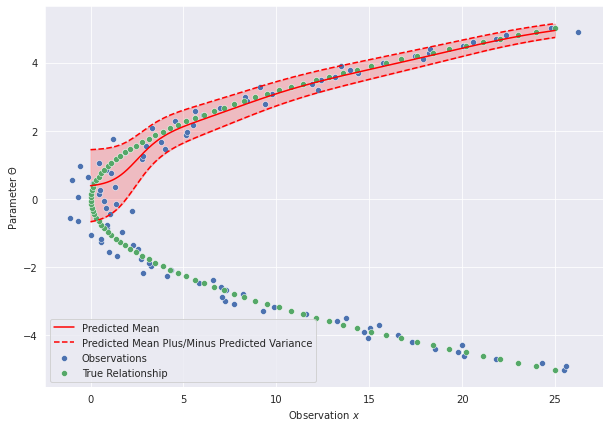

In [15]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

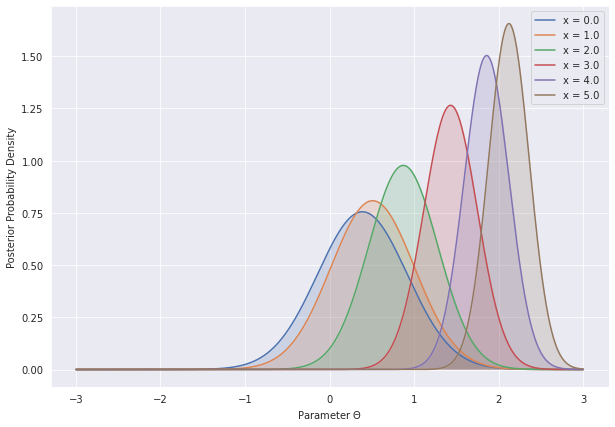

In [16]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

# Linear Regression

In [ ]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.range_scaling(data)
amortised_dist = amortised.LinearRegression(approx_dist, ndim, prngkey, order=20, preprocessing=preprocessing)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
amortised_dist.initialise(data)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
prngkey = jax.random.PRNGKey(42)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

In [ ]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)